### Грузим данные и либы

In [1]:
import pandas as pd
import numpy as np
import time

In [2]:
df = pd.read_parquet('avito_cv2vac.pq')
# ('./drive/MyDrive/AAA/course/avito_cv2vac.pq')

In [7]:
df.shape

(232819, 14)

In [8]:
df.head()

,User_id,Item_id,EventDate,last_resume_id,event_name,Region,City,session_hash,microcat_name,Platform_id,res_title,res_des,vac_title,vac_des
0,372831461,1410897751247,2023-03-13 16:01:07,287948381,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Санкт-Петербург,7813611419044570652,Полный день,2,Ищу работу,"Ищу работу технологом,нач.смены.Опыт работы 3 ...",Начальник охраны объекта,Обязанности: контроль работы постов охраны​ по...
1,366472774,768439750232,2023-03-13 14:56:13,293106495,In App Calls / Контакт IAC (в различных сценар...,Вологодская область,Череповец,2800082180641601867,Полный день,4,Ищу работу,м/ч 25л образование среднее профессиональное(п...,"Водитель, монтажник",Только с желанием работать и зарабатывать\nТрe...
2,366669357,1429452751612,2023-03-13 19:57:56,317525264,Пользовательские события / Объявления / Просмо...,Самарская область,Самара,6266140651757332598,Сменный график,3,Ищу подработку,"ищу работу, подработку с 9,00-17,00, с возможн...",Медицинская сестра в клинику эстетической меди...,Медицинская сестра в клинику эстетической меди...
3,370281435,1422666754936,2023-03-13 19:03:54,323785715,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Колпино,6498496299285393322,Сменный график,3,Для желающих подработать на дому,Без вложения средств. на компьютере.подробност...,Оператор станции обезвоживания сырого осадка,— Весь технологический процесс станции обезвож...
4,370281435,689631256782,2023-03-13 18:42:42,323785715,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Санкт-Петербург,6498496299285393322,Сменный график,3,Для желающих подработать на дому,Без вложения средств. на компьютере.подробност...,Дворник на АЗС (62),Требуется дворник для содержания территории в ...


Функция для добавления метки 1 к исходным данным и создания метки 0, меняя цифру в цикле, можно менять количество созданных данных с меткой 0
(при значении 1 - соотношение метки 1 и 0 50% к 50%) 465638 rows × 15 columns

In [ ]:
def get_labels(df):
  df['label'] = 1
  df_1 = df.iloc[:, :-3]
  df_2 = df.iloc[:, -3:]
  x = 0

  while x < 1:
    df_1 = df_1.sample(frac=1).reset_index(drop=True)
    df_2 = df_2.sample(frac=1).reset_index(drop=True)
    df_3 = pd.concat([df_1, df_2], axis = 1).drop_duplicates()
    df_3['label'] = 0
    df = pd.concat([df, df_3], axis = 0).reset_index(drop=True)
    x += 1

  df = df.drop_duplicates(subset=df.columns.difference(['label', 'vac_des', 'res_des']), keep='first')

  return df

In [ ]:

get_labels(df)

### Идеи для поиска:

0. Бейзлайн на частотном анализе (типа подсчет уникальных слов)
1. Эмбеддинги Берта --> Расстояние
2. Сиамские сети --> Расстояние
3. Triplet Loss (?)
4. ALS и фишки про рекомендации (?)

### Бейзлайн на эмбеддингах ruBERT'а

In [11]:
# ! pip install transformers

In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
from scipy import spatial
import random

Возьмем BERT'а для текстов на русском от DeepPavlov'а (можно пробовать другие варианты)

In [4]:
rubert_tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased", max_len=512)

rubert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
from tqdm import tqdm

In [6]:
class EmbedBaseline:
    def __init__(self, model, tokenizer, device="cpu"):
        self.tokenizer = tokenizer
        self.model = model
        self.device = device
        self.model = self.model.to(self.device)
  
    def get_bert_embed(self, text):
        text = "[CLS] " + text + " [SEP]"
        tokenized_text = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        tokenized_text = tokenized_text.to(self.device)
        with torch.no_grad():
            model_output = self.model(**{k: v.to(self.model.device) for k, v in tokenized_text.items()})

        embeddings = model_output.last_hidden_state[:, 0, :]
        # нормализуем
        embeddings = torch.nn.functional.normalize(embeddings)
        return embeddings[0].cpu().numpy()

  
    def calculate_cosine_similarity(self, vac_des, cv_des):
        vac_vec = self.get_bert_embed(vac_des)
        cv_vec = self.get_bert_embed(cv_des)

        cosine_similarity = 1 - float(spatial.distance.cosine(vac_vec, cv_vec))

        return cosine_similarity


    def get_top_n_cv(self, vac_des, vac_cluster, df, top_n=5):
        res = {}
        possible_cv = df.loc[df['cluster'] == vac_cluster, 'res_des'].values[:100]

        for cv_des_ind in tqdm(range(len(possible_cv))):
          cv_des = possible_cv[cv_des_ind]
          res[cv_des] = self.calculate_cosine_similarity(vac_des, cv_des)

        return sorted(res.items(), key=lambda x: -x[1])[:top_n]    


In [7]:
baseline_model = EmbedBaseline(rubert, rubert_tokenizer,"cuda")

In [13]:
import time
time_start = time.time()
emb = baseline_model.get_bert_embed("я шел по дороге очень долго домой")
time.time()- time_start

0.2998392581939697

In [8]:
import time

In [18]:
embd = []
bad_idx = []
for idx,elem in tqdm(enumerate(df["res_des"].values)):
    try:
        embd.append(baseline_model.get_bert_embed(elem))
    except:
        bad_idx.append(idx)

232819it [21:45, 178.32it/s] 


In [27]:
bad_idx


[75,
 210,
 242,
 243,
 280,
 281,
 282,
 343,
 344,
 345,
 346,
 347,
 348,
 450,
 607,
 608,
 609,
 627,
 692,
 961,
 962,
 997,
 1254,
 1263,
 1264,
 1505,
 1525,
 1526,
 1617,
 1734,
 1735,
 1736,
 1737,
 1738,
 1761,
 1762,
 1816,
 1893,
 1930,
 1939,
 2015,
 2025,
 2104,
 2942,
 3760,
 5807,
 5808,
 5809,
 5810,
 5811,
 5812,
 5984,
 7444,
 10394,
 16901,
 18842,
 18843,
 18844,
 28116,
 28434,
 28435,
 31824,
 31825,
 31826,
 31827,
 32776,
 32777,
 35175,
 35176,
 41586,
 43954,
 43955,
 43956,
 46890,
 46891,
 47254,
 47255,
 47256,
 71131,
 72509,
 72510,
 73007,
 74025,
 85670,
 97683,
 102854,
 111565,
 113094,
 117862,
 118139,
 118140,
 124255,
 131434,
 139641,
 139642,
 139643,
 139644,
 139645,
 139646,
 140936,
 140937,
 144373,
 150761,
 150762,
 150763,
 150764,
 150765,
 150766,
 153154,
 153155,
 153156,
 153157,
 153158,
 153159,
 153160,
 162886,
 162887,
 162888,
 162889,
 167153,
 184644,
 190795,
 190796,
 190797,
 196142,
 210977,
 215445,
 215446,
 215447,


In [39]:
print(df["res_des"].values[346])

ОБРАЗОВАНИЕ
2003-2008 - Волгоградский Государственный Университет (далее - ВолГУ). 
Факультет лингвистики и межкультурной коммуникации. Специальность «Перевод и переводоведение». Квалификация «Лингвист. Переводчик» (1-й язык – франц., 2-й язык – англ.). Диплом с отличием.
22.03.07 - 21.05.07 -  ВолГУ. 
Программа повышения квалификации «Актуальные проблемы устного (последовательного и синхронного) перевода».
ОПЫТ РАБОТЫ
19.10.2015–31.01.2016 – ООО «Бизнес-Партнёр».
Переводчик (англ. яз.).
Письменный перевод: отчёты, протоколы совещаний, приказы, предписания, нормативная документация, официальные письма. Устный перевод: на совещаниях и стройплощадке.
Админ. поддержка (подача заявок, оформление пропусков и т.д.).
26.03.2012–30.09.2014–OOO «ККС-Инжиниринг».
Письмен. переводы – нормативная документация, отчёты, деловая переписка; устн. переводы – на совещаниях и строительной площадке. Составление глоссария. Административная поддержка.
19.08.2010 – 23.03.2012 - Бюро переводов «Apex-Pro» (ООО

In [40]:
data_bed = df.iloc [bad_idx]
data_bed
data_bed.to_parquet('data_bed.pq')

In [50]:
print(np.array(embd).shape)

(232689, 768)


In [59]:
df = pd.read_parquet('avito_cv2vac.pq')
df

,User_id,Item_id,EventDate,last_resume_id,event_name,Region,City,session_hash,microcat_name,Platform_id,res_title,res_des,vac_title,vac_des
0,372831461,1410897751247,2023-03-13 16:01:07,287948381,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Санкт-Петербург,7813611419044570652,Полный день,2,Ищу работу,"Ищу работу технологом,нач.смены.Опыт работы 3 ...",Начальник охраны объекта,Обязанности: контроль работы постов охраны​ по...
1,366472774,768439750232,2023-03-13 14:56:13,293106495,In App Calls / Контакт IAC (в различных сценар...,Вологодская область,Череповец,2800082180641601867,Полный день,4,Ищу работу,м/ч 25л образование среднее профессиональное(п...,"Водитель, монтажник",Только с желанием работать и зарабатывать\nТрe...
2,366669357,1429452751612,2023-03-13 19:57:56,317525264,Пользовательские события / Объявления / Просмо...,Самарская область,Самара,6266140651757332598,Сменный график,3,Ищу подработку,"ищу работу, подработку с 9,00-17,00, с возможн...",Медицинская сестра в клинику эстетической меди...,Медицинская сестра в клинику эстетической меди...
3,370281435,1422666754936,2023-03-13 19:03:54,323785715,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Колпино,6498496299285393322,Сменный график,3,Для желающих подработать на дому,Без вложения средств. на компьютере.подробност...,Оператор станции обезвоживания сырого осадка,— Весь технологический процесс станции обезвож...
4,370281435,689631256782,2023-03-13 18:42:42,323785715,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Санкт-Петербург,6498496299285393322,Сменный график,3,Для желающих подработать на дому,Без вложения средств. на компьютере.подробност...,Дворник на АЗС (62),Требуется дворник для содержания территории в ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232814,741021250053,1427757755588,2023-03-13 15:50:07,1432203250045,Чат / События полученные через AMQP / Отправка...,Москва,Москва,5616536396553863727,Вахтовый метод,3,Няня для ребенка с проживанием,"Добрая, спокойная, уравновешенная, неконфликтн...",Требуется: Няня-гувернантка,"Требуется: Няня-гувернантка, Московская област..."
232815,313382250061,1421789250018,2023-03-13 12:20:20,1432203750857,Пользовательские события / Объявления / Просмо...,Забайкальский край,Чита,6283812260717342948,Свободный график,3,"Разнорабочий, слесарь, гидромониторщик",Спакойный трудолюбивый,Водитель-Развозчик Забытые ключи,Водитель на личном транспорте. Подработка или ...
232816,442660750128,1432056750361,2023-03-13 23:49:45,1432209500911,Чат / События полученные через AMQP / Отправка...,Москва,Москва,8199703742503214578,Свободный график,4,Маркетолог,"Работаю в продажах , сейчас закончила обучение...",Подработка в рекламной компании,"Привет, мы ищем сотрудника готового совмещать ..."
232817,442660750128,1430745502106,2023-03-13 23:41:06,1432209500911,Чат / События полученные через AMQP / Отправка...,Москва,Москва,8199703742503214578,Полный день,4,Маркетолог,"Работаю в продажах , сейчас закончила обучение...",Бренд менеджер полного цикла,Добрый день! Наша компания занимается рознично...


In [60]:
df = df.drop(index=bad_idx)
df.reset_index(drop= True , inplace= True)
df = df.assign(embd=embd)
df

,User_id,Item_id,EventDate,last_resume_id,event_name,Region,City,session_hash,microcat_name,Platform_id,res_title,res_des,vac_title,vac_des,embd
0,372831461,1410897751247,2023-03-13 16:01:07,287948381,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Санкт-Петербург,7813611419044570652,Полный день,2,Ищу работу,"Ищу работу технологом,нач.смены.Опыт работы 3 ...",Начальник охраны объекта,Обязанности: контроль работы постов охраны​ по...,"[0.010668044, -0.009598919, 0.001550561, 0.004..."
1,366472774,768439750232,2023-03-13 14:56:13,293106495,In App Calls / Контакт IAC (в различных сценар...,Вологодская область,Череповец,2800082180641601867,Полный день,4,Ищу работу,м/ч 25л образование среднее профессиональное(п...,"Водитель, монтажник",Только с желанием работать и зарабатывать\nТрe...,"[0.016074648, -0.008798098, -0.011233768, 0.00..."
2,366669357,1429452751612,2023-03-13 19:57:56,317525264,Пользовательские события / Объявления / Просмо...,Самарская область,Самара,6266140651757332598,Сменный график,3,Ищу подработку,"ищу работу, подработку с 9,00-17,00, с возможн...",Медицинская сестра в клинику эстетической меди...,Медицинская сестра в клинику эстетической меди...,"[0.021342682, -0.00420893, 0.024091521, -0.016..."
3,370281435,1422666754936,2023-03-13 19:03:54,323785715,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Колпино,6498496299285393322,Сменный график,3,Для желающих подработать на дому,Без вложения средств. на компьютере.подробност...,Оператор станции обезвоживания сырого осадка,— Весь технологический процесс станции обезвож...,"[-0.0031436747, -0.0136293005, -0.020839976, -..."
4,370281435,689631256782,2023-03-13 18:42:42,323785715,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Санкт-Петербург,6498496299285393322,Сменный график,3,Для желающих подработать на дому,Без вложения средств. на компьютере.подробност...,Дворник на АЗС (62),Требуется дворник для содержания территории в ...,"[-0.0031436747, -0.0136293005, -0.020839976, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232684,741021250053,1427757755588,2023-03-13 15:50:07,1432203250045,Чат / События полученные через AMQP / Отправка...,Москва,Москва,5616536396553863727,Вахтовый метод,3,Няня для ребенка с проживанием,"Добрая, спокойная, уравновешенная, неконфликтн...",Требуется: Няня-гувернантка,"Требуется: Няня-гувернантка, Московская област...","[0.0022404203, 0.006727459, -0.015258369, -0.0..."
232685,313382250061,1421789250018,2023-03-13 12:20:20,1432203750857,Пользовательские события / Объявления / Просмо...,Забайкальский край,Чита,6283812260717342948,Свободный график,3,"Разнорабочий, слесарь, гидромониторщик",Спакойный трудолюбивый,Водитель-Развозчик Забытые ключи,Водитель на личном транспорте. Подработка или ...,"[0.00432457, 0.0014639987, -0.011987823, 0.003..."
232686,442660750128,1432056750361,2023-03-13 23:49:45,1432209500911,Чат / События полученные через AMQP / Отправка...,Москва,Москва,8199703742503214578,Свободный график,4,Маркетолог,"Работаю в продажах , сейчас закончила обучение...",Подработка в рекламной компании,"Привет, мы ищем сотрудника готового совмещать ...","[-0.0034206288, -0.004966837, -0.0070581813, -..."
232687,442660750128,1430745502106,2023-03-13 23:41:06,1432209500911,Чат / События полученные через AMQP / Отправка...,Москва,Москва,8199703742503214578,Полный день,4,Маркетолог,"Работаю в продажах , сейчас закончила обучение...",Бренд менеджер полного цикла,Добрый день! Наша компания занимается рознично...,"[-0.0034206288, -0.004966837, -0.0070581813, -..."


In [2]:
import pickle
import time

In [ ]:
# file = open("embd.pq", "wb")
# pickle.dump(df, file=file)

In [3]:
file = open("embd.pq", "rb")
unpickler = pickle.Unpickler(file)
df = unpickler.load()

In [4]:
df

,User_id,Item_id,EventDate,last_resume_id,event_name,Region,City,session_hash,microcat_name,Platform_id,res_title,res_des,vac_title,vac_des,embd
0,372831461,1410897751247,2023-03-13 16:01:07,287948381,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Санкт-Петербург,7813611419044570652,Полный день,2,Ищу работу,"Ищу работу технологом,нач.смены.Опыт работы 3 ...",Начальник охраны объекта,Обязанности: контроль работы постов охраны​ по...,"[0.010668044, -0.009598919, 0.001550561, 0.004..."
1,366472774,768439750232,2023-03-13 14:56:13,293106495,In App Calls / Контакт IAC (в различных сценар...,Вологодская область,Череповец,2800082180641601867,Полный день,4,Ищу работу,м/ч 25л образование среднее профессиональное(п...,"Водитель, монтажник",Только с желанием работать и зарабатывать\nТрe...,"[0.016074648, -0.008798098, -0.011233768, 0.00..."
2,366669357,1429452751612,2023-03-13 19:57:56,317525264,Пользовательские события / Объявления / Просмо...,Самарская область,Самара,6266140651757332598,Сменный график,3,Ищу подработку,"ищу работу, подработку с 9,00-17,00, с возможн...",Медицинская сестра в клинику эстетической меди...,Медицинская сестра в клинику эстетической меди...,"[0.021342682, -0.00420893, 0.024091521, -0.016..."
3,370281435,1422666754936,2023-03-13 19:03:54,323785715,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Колпино,6498496299285393322,Сменный график,3,Для желающих подработать на дому,Без вложения средств. на компьютере.подробност...,Оператор станции обезвоживания сырого осадка,— Весь технологический процесс станции обезвож...,"[-0.0031436747, -0.0136293005, -0.020839976, -..."
4,370281435,689631256782,2023-03-13 18:42:42,323785715,Пользовательские события / Объявления / Просмо...,Санкт-Петербург,Санкт-Петербург,6498496299285393322,Сменный график,3,Для желающих подработать на дому,Без вложения средств. на компьютере.подробност...,Дворник на АЗС (62),Требуется дворник для содержания территории в ...,"[-0.0031436747, -0.0136293005, -0.020839976, -..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
232684,741021250053,1427757755588,2023-03-13 15:50:07,1432203250045,Чат / События полученные через AMQP / Отправка...,Москва,Москва,5616536396553863727,Вахтовый метод,3,Няня для ребенка с проживанием,"Добрая, спокойная, уравновешенная, неконфликтн...",Требуется: Няня-гувернантка,"Требуется: Няня-гувернантка, Московская област...","[0.0022404203, 0.006727459, -0.015258369, -0.0..."
232685,313382250061,1421789250018,2023-03-13 12:20:20,1432203750857,Пользовательские события / Объявления / Просмо...,Забайкальский край,Чита,6283812260717342948,Свободный график,3,"Разнорабочий, слесарь, гидромониторщик",Спакойный трудолюбивый,Водитель-Развозчик Забытые ключи,Водитель на личном транспорте. Подработка или ...,"[0.00432457, 0.0014639987, -0.011987823, 0.003..."
232686,442660750128,1432056750361,2023-03-13 23:49:45,1432209500911,Чат / События полученные через AMQP / Отправка...,Москва,Москва,8199703742503214578,Свободный график,4,Маркетолог,"Работаю в продажах , сейчас закончила обучение...",Подработка в рекламной компании,"Привет, мы ищем сотрудника готового совмещать ...","[-0.0034206288, -0.004966837, -0.0070581813, -..."
232687,442660750128,1430745502106,2023-03-13 23:41:06,1432209500911,Чат / События полученные через AMQP / Отправка...,Москва,Москва,8199703742503214578,Полный день,4,Маркетолог,"Работаю в продажах , сейчас закончила обучение...",Бренд менеджер полного цикла,Добрый день! Наша компания занимается рознично...,"[-0.0034206288, -0.004966837, -0.0070581813, -..."


In [5]:
data = df["embd"].values
data_new = np.zeros((data.shape[0], 768))
for i, elem in enumerate(data):
    data_new[i] = elem
data_new.shape

(232689, 768)

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
scaler = StandardScaler()
X_train, X_val, _, _ = train_test_split(data_new, np.zeros(data_new.shape[0]), test_size=0.33, random_state=42)
model = scaler.fit(X_train)
scaled_data_train = model.transform(X_train)
scaled_data_val = model.transform(X_val)

In [13]:
len(df["vac_title"].unique())

51369

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [20]:
for idx, elem in enumerate(scaled_data_train):
    if elem.any() == np.nan:
        print(idx)

In [21]:
kmeans = KMeans(n_clusters=250, random_state=42, n_init="auto")
kmeans.fit(scaled_data_train)

KMeans(n_clusters=250, n_init='auto', random_state=42)

In [24]:
preds = kmeans.predict(scaled_data_val)
score = silhouette_score(scaled_data_val, preds)

In [25]:
score

0.06497801596644089

In [26]:
kmeans100 = KMeans(n_clusters=100, random_state=42, n_init="auto")
kmeans100.fit(scaled_data_train)
preds100 = kmeans100.predict(scaled_data_val)
score100 = silhouette_score(scaled_data_val, preds100)
score100

0.0515203997223006

In [27]:
kmeans1000 = KMeans(n_clusters=1000, random_state=42, n_init="auto")
kmeans1000.fit(scaled_data_train)
preds1000 = kmeans1000.predict(scaled_data_val)
score1000 = silhouette_score(scaled_data_val, preds1000)
score1000

0.10134675367554902

In [18]:
strat_time = time.time()
kmeans2500 = KMeans(n_clusters=2500, random_state=42, n_init="auto")
kmeans2500.fit(scaled_data_train)
preds2500 = kmeans2500.predict(scaled_data_val)
score2500 = silhouette_score(scaled_data_val, preds2500)
score2500, time.time() - strat_time

(0.15499101640924823, 308.48806047439575)

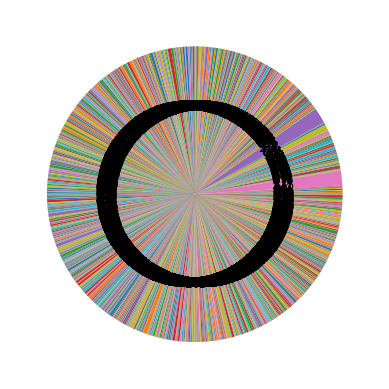

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
_, count = np.unique(preds2500, return_counts=True)
vals = count
labels = np.arange(0, len(count))
plt.pie(vals, autopct='%.0f%%')
plt.show()

In [12]:
strat_time = time.time()
kmeans5000 = KMeans(n_clusters=5000, random_state=42, n_init="auto")
kmeans5000.fit(scaled_data_train)
preds5000 = kmeans5000.predict(scaled_data_val)
score5000 = silhouette_score(scaled_data_val, preds5000)
score5000, time.time() - strat_time

(0.2191899126448443, 594.6005177497864)

In [8]:
strat_time = time.time()
kmeans20000 = KMeans(n_clusters=20000, random_state=42, n_init="auto")
kmeans20000.fit(scaled_data_train)
preds20000 = kmeans20000.predict(scaled_data_val)
score20000 = silhouette_score(scaled_data_val, preds20000)
score20000, time.time() - strat_time

(0.4609219533858944, 1744.3801605701447)

In [13]:
_, count = np.unique(preds20000, return_counts=True)
with open("count.txt", 'w') as f:
    for i, elem in enumerate(count):
        f.write(f'cluster {i} count {elem}\n')

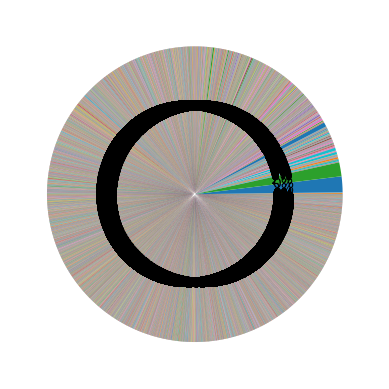

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

vals = count
labels = np.arange(0, len(count))
plt.pie(vals, autopct='%.0f%%')
plt.show()

In [14]:
strat_time = time.time()
kmeans50000 = KMeans(n_clusters=51369, random_state=42, n_init="auto")
kmeans50000.fit(scaled_data_train)
preds50000 = kmeans50000.predict(scaled_data_val)
score50000 = silhouette_score(scaled_data_val, preds50000)
score50000, time.time() - strat_time

(0.6724469215861106, 3987.3859260082245)

In [9]:
df = pd.read_parquet('avito_cv2vac_with_ranks_clear.pq')
df

,User_id,Item_id,EventDate,last_resume_id,event_name,Region,City,session_hash,microcat_name,Platform_id,res_title,res_des,vac_title,vac_des,label,rank,max_rank
0,1.030430e+12,1.353529e+12,2023-03-13 11:21:22,1.427381e+12,Пользовательские события / Объявления / Просмо...,Москва,Москва,8.753473e+18,Полный день,3.0,Подработка,"Бригадир раздачи газет на ж/ д станциях, интер...",Диспетчер оператор (менеджер),! ! ! ВНИМАНИЕ ! ! ! ОЧЕНЬ ВАЖНО ! ! ! требуют...,1,1,1
1,8.000233e+11,1.237305e+12,2023-03-13 03:02:08,1.401474e+12,Чат / События полученные через AMQP / Отправка...,Иркутская область,Братск,8.963607e+18,Сменный график,3.0,Не имеет значения,Срочно нужна работа !!!,Сборщики в магазин,! В гипермаркет требуются сборщики заказов.\n\...,1,1,2
2,1.073960e+12,1.237305e+12,2023-03-13 13:18:16,1.314115e+12,Чат / События полученные через AMQP / Отправка...,Иркутская область,Братск,2.662302e+18,Сменный график,4.0,Начинающий специалист,"Ответственная ,умею общаться с людьми",Сборщики в магазин,! В гипермаркет требуются сборщики заказов.\n\...,1,2,2
3,1.128231e+12,1.247251e+12,2023-03-13 10:39:39,1.429179e+12,Чат / События полученные через AMQP / Отправка...,Воронежская область,Воронеж,4.597737e+18,Сменный график,2.0,Продавец консультант,Продавец консультант,Сборщики заказов,! В гипермаркет требуются сборщики заказов.\n\...,1,1,1
4,6.528780e+11,1.121617e+12,2023-03-13 01:15:04,1.425790e+12,Чат / События полученные через AMQP / Отправка...,Московская область,Химки,6.790487e+17,Вахтовый метод,3.0,Медсестра на дом капельницы уколы,Я Настя из Таджикистана год рождения 1990 стаж...,"Работа вахта на складе 15/15, с проживанием)","! ВАХТА в МОСКОВСКОЙ ОБЛАСТИ !\n\nВОЗМОЖНО, БЕ...",1,1,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465633,8.245448e+11,1.427353e+12,2023-03-13 13:45:18,1.423216e+12,Чат / События полученные через AMQP / Отправка...,Москва,Москва,6.613096e+17,Сменный график,3.0,Официантка работа,Ответственная исполнительная пунктуальность,Помощник на обработку документов на 4 часа,Требуется помощник на обработку входящей докум...,0,0,0
465634,1.181303e+12,1.373503e+12,2023-03-13 08:20:30,1.431757e+12,Пользовательские события / Объявления / Просмо...,Псковская область,Великие Луки,3.857741e+18,Сменный график,3.0,"Любая работа, подработка",Быстро обучаюсь,Статрший администратор службы приема и размещения,"Описание работодателя:\nОтель 4 звезды, г. А...",0,0,0
465635,1.127932e+12,1.428407e+12,2023-03-13 19:20:25,1.429851e+12,Чат / События полученные через AMQP / Отправка...,Татарстан,Набережные Челны,1.586361e+18,Вахтовый метод,4.0,Репетитор по английскому языку,стрессоустойчивый и коммуникабельный профессионал,Вахта проживание + питание/Упаковщик/20 смен,Вахта 15 смен с питанием и проживанием - ЗВОНИ...,0,0,0
465636,9.636738e+11,1.431304e+12,2023-03-13 13:14:56,1.341265e+12,Пользовательские события / Объявления / Просмо...,Башкортостан,Стерлитамак,5.963610e+18,Полный день,3.0,Тракторист на мтз 82,ищу работу на своем тракторе мтз 82!,Менеджер по работе с клиентами,Требуется сотрудница в сервисный центр/магазин...,0,0,0


In [11]:
strat_time = time.time()
res_title = []
for item in df["res_title"].values:
    res_title.append(baseline_model.get_bert_embed(item))
time.time() - strat_time

2036.1013689041138

In [12]:
strat_time = time.time()
res_des = []
for item in df["res_des"].values:
    res_des.append(baseline_model.get_bert_embed(item))
time.time() - strat_time

2547.3952403068542

In [13]:
strat_time = time.time()
vac_title = []
for item in df["vac_title"].values:
    vac_title.append(baseline_model.get_bert_embed(item))
time.time() - strat_time

2041.8442242145538

In [14]:
strat_time = time.time()
vac_des = []
for item in df["vac_des"].values:
    vac_des.append(baseline_model.get_bert_embed(item))
time.time() - strat_time

7186.045120477676

In [18]:
file = open("res_title_embd.pq", "wb")
pickle.dump(res_title, file=file)
file = open("res_des_embd.pq", "wb")
pickle.dump(res_des, file=file)
file = open("vac_title_embd.pq", "wb")
pickle.dump(vac_title, file=file)
file = open("vac_des_embd.pq", "wb")
pickle.dump(vac_des, file=file)


In [19]:
df["res_title_embd"] = res_title
df["res_des_embd"] = res_des
df["vac_title_embd"] = vac_title
df["vac_des_embd"] = vac_des

In [20]:
file = open("final_data.parquet", "wb")
pickle.dump(df, file=file)

In [ ]:
df

In [21]:
file = open("final_data.parquet", "rb")
unpickler = pickle.Unpickler(file)
data = unpickler.load()
data

,User_id,Item_id,EventDate,last_resume_id,event_name,Region,City,session_hash,microcat_name,Platform_id,...,res_des,vac_title,vac_des,label,rank,max_rank,res_title_embd,res_des_embd,vac_title_embd,vac_des_embd
0,1.030430e+12,1.353529e+12,2023-03-13 11:21:22,1.427381e+12,Пользовательские события / Объявления / Просмо...,Москва,Москва,8.753473e+18,Полный день,3.0,...,"Бригадир раздачи газет на ж/ д станциях, интер...",Диспетчер оператор (менеджер),! ! ! ВНИМАНИЕ ! ! ! ОЧЕНЬ ВАЖНО ! ! ! требуют...,1,1,1,"[0.0046879807, 0.0025343422, 0.00092256616, 0....","[0.0075302753, 0.0048114313, -0.012267461, 0.0...","[-4.150334e-05, -0.00067646155, -0.0026508528,...","[0.029237885, -0.005808992, -0.006370289, -0.0..."
1,8.000233e+11,1.237305e+12,2023-03-13 03:02:08,1.401474e+12,Чат / События полученные через AMQP / Отправка...,Иркутская область,Братск,8.963607e+18,Сменный график,3.0,...,Срочно нужна работа !!!,Сборщики в магазин,! В гипермаркет требуются сборщики заказов.\n\...,1,1,2,"[0.000846693, 0.004513962, -0.0033094776, 0.00...","[0.0011214598, 0.0035717497, -0.017180806, 0.0...","[0.0010705718, 0.0061573614, -0.013012602, -0....","[0.006657418, -0.0015002823, -0.015911406, 0.0..."
2,1.073960e+12,1.237305e+12,2023-03-13 13:18:16,1.314115e+12,Чат / События полученные через AMQP / Отправка...,Иркутская область,Братск,2.662302e+18,Сменный график,4.0,...,"Ответственная ,умею общаться с людьми",Сборщики в магазин,! В гипермаркет требуются сборщики заказов.\n\...,1,2,2,"[0.005007821, 0.0016753533, -0.006774828, 0.00...","[-0.0025696247, 0.0018040005, -0.012140248, 0....","[0.0010705718, 0.0061573614, -0.013012602, -0....","[0.006657418, -0.0015002823, -0.015911406, 0.0..."
3,1.128231e+12,1.247251e+12,2023-03-13 10:39:39,1.429179e+12,Чат / События полученные через AMQP / Отправка...,Воронежская область,Воронеж,4.597737e+18,Сменный график,2.0,...,Продавец консультант,Сборщики заказов,! В гипермаркет требуются сборщики заказов.\n\...,1,1,1,"[0.004016971, 0.0014357736, -0.0076328064, 0.0...","[0.004016971, 0.0014357736, -0.0076328064, 0.0...","[-0.0021627161, 0.003360599, -0.008386532, 0.0...","[0.003956883, 0.0007468789, -0.016819667, 0.00..."
4,6.528780e+11,1.121617e+12,2023-03-13 01:15:04,1.425790e+12,Чат / События полученные через AMQP / Отправка...,Московская область,Химки,6.790487e+17,Вахтовый метод,3.0,...,Я Настя из Таджикистана год рождения 1990 стаж...,"Работа вахта на складе 15/15, с проживанием)","! ВАХТА в МОСКОВСКОЙ ОБЛАСТИ !\n\nВОЗМОЖНО, БЕ...",1,1,21,"[-0.0017184585, 0.004957207, -0.008810926, -0....","[0.0017326836, 7.1683426e-05, -0.0052934275, -...","[-0.0009735497, 0.0011112504, -0.0040494567, 0...","[0.002794954, 7.651041e-05, -0.020990502, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465633,8.245448e+11,1.427353e+12,2023-03-13 13:45:18,1.423216e+12,Чат / События полученные через AMQP / Отправка...,Москва,Москва,6.613096e+17,Сменный график,3.0,...,Ответственная исполнительная пунктуальность,Помощник на обработку документов на 4 часа,Требуется помощник на обработку входящей докум...,0,0,0,"[0.006547952, 0.0054424177, -0.015928585, -0.0...","[-0.0043091015, 0.004353465, 0.0011329616, -0....","[-0.0038939419, 0.0053313468, 0.0020655578, 0....","[0.0055214255, 0.0034447236, 0.0068369927, 0.0..."
465634,1.181303e+12,1.373503e+12,2023-03-13 08:20:30,1.431757e+12,Пользовательские события / Объявления / Просмо...,Псковская область,Великие Луки,3.857741e+18,Сменный график,3.0,...,Быстро обучаюсь,Статрший администратор службы приема и размещения,"Описание работодателя:\nОтель 4 звезды, г. А...",0,0,0,"[0.008918729, 0.005058712, -0.01215993, 0.0063...","[0.0063389684, 0.003659173, -0.015682653, 0.00...","[-0.0020211302, 0.0025118522, -0.008361364, 0....","[0.01224619, 0.009867562, -0.0032211435, -0.00..."
465635,1.127932e+12,1.428407e+12,2023-03-13 19:20:25,1.429851e+12,Чат / События полученные через AMQP / Отправка...,Татарстан,Набережные Челны,1.586361e+18,Вахтовый метод,4.0,...,ст